In [1]:
import pandas as pd
import os

In [2]:
import pickle

In [4]:
smart_df = pd.read_csv('../../clean_data/only_name_smart.csv', index_col=0)

In [5]:
smart_df.head()

,goal_name,goal_name_key_pos,goal_weight,goal_words,goal_aver_word_len,goal_verbs_counter,goal_nouns_counter,goal_numr_counter,goal_adj_counter,goal_digit_counter,label_specific,label_attainable,label_time_bound,label_unambiguity
25,повысить уровень знаний возможности компьютера,повысить уровень знание возможность компьютер,1.2060,5,8.4,1,4,0,0,0,1,1,0,1
70,познание инноваций,познание инновация,0.6429,2,8.5,0,2,0,0,0,1,1,0,1
124,fdd,NaN,0.0000,1,3.0,0,0,0,0,0,0,0,0,1
136,знания,знание,0.0123,1,6.0,0,1,0,0,0,0,1,0,1
172,получить больше знаний и умений,получить знание умение,0.0944,5,5.4,1,2,0,0,0,0,0,0,1


In [7]:
smart = smart_df.copy()

In [8]:
smart.drop(columns=['goal_name'], inplace=True)

In [32]:
smart_text_vectors = smart[['goal_name_key_pos', 'label_specific', 'label_attainable', 'label_time_bound']]
smart_features = smart.drop(columns=['goal_name_key_pos'])

In [10]:
from sklearn.model_selection import train_test_split

### Label specific

#### Features approach

In [11]:
specific_features = smart_features.drop(columns=['label_attainable', 'label_time_bound', 'label_unambiguity'])

In [12]:
X = specific_features.drop('label_specific', axis=1)
y = specific_features['label_specific']

In [13]:
X.shape

(899, 8)

In [15]:
y.shape

(899,)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_train.head()

,goal_weight,goal_words,goal_aver_word_len,goal_verbs_counter,goal_nouns_counter,goal_numr_counter,goal_adj_counter,goal_digit_counter
16946,2.1651,4,6.50,1,2,0,1,0
13196,0.3646,6,5.67,2,2,0,1,0
16543,0.6667,2,7.50,1,1,0,0,0
11362,0.0661,2,10.00,0,1,0,1,0
4642,1.0059,11,7.18,0,5,0,3,0


In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
mms = MinMaxScaler()

In [20]:
X_train_scaled = mms.fit_transform(X_train)

In [21]:
X_test_scaled = mms.fit_transform(X_test)

In [22]:
from xgboost import XGBClassifier

In [23]:
spec_xgb = XGBClassifier()

In [24]:
spec_xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
y_pred = spec_xgb.predict(X_test_scaled)

In [29]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.69      0.64       106
           1       0.44      0.35      0.39        74

    accuracy                           0.55       180
   macro avg       0.52      0.52      0.52       180
weighted avg       0.54      0.55      0.54       180



In [28]:
accuracy_score(y_test, y_pred)

0.55

In [30]:
f1_score(y_test, y_pred)

0.39097744360902253

In [31]:
roc_auc_score(y_test, y_pred)

0.5200152983171851

In [49]:
with open('models/specific_feat_xgb.pkl', 'wb') as f:
    pickle.dump(spec_xgb, f)

#### Vectors approach

In [33]:
specific_vectors = smart_text_vectors.drop(columns=['label_attainable', 'label_time_bound'])

In [34]:
specific_vectors.columns

Index(['goal_name_key_pos', 'label_specific'], dtype='object')

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [36]:
text = specific_vectors['goal_name_key_pos']
y = specific_vectors['label_specific']

In [40]:
text.fillna('', inplace=True)

In [41]:
text

25           повысить уровень знание возможность компьютер
70                                      познание инновация
124                                                       
136                                                 знание
172                                 получить знание умение
                               ...                        
17982                                  отдалиться молодёжь
17983                найти интересный работа работать мозг
17991                              быть интересный общение
18015    получить сертификат эксперт региональный чемпи...
18017                                закончить аспирантура
Name: goal_name_key_pos, Length: 899, dtype: object

In [42]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [43]:
X.shape

(899, 893)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [45]:
spec_v_xgb = XGBClassifier()

In [46]:
spec_v_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
y_pred = spec_v_xgb.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.69      0.61       101
           1       0.38      0.24      0.29        79

    accuracy                           0.49       180
   macro avg       0.46      0.47      0.45       180
weighted avg       0.47      0.49      0.47       180



In [49]:
accuracy_score(y_test, y_pred)

0.49444444444444446

In [50]:
f1_score(y_test, y_pred)

0.2945736434108527

In [51]:
roc_auc_score(y_test, y_pred)

0.4667878180223085

In [65]:
with open('models/specific_vect_xgb.pkl', 'wb') as f:
    pickle.dump(spec_v_xgb, f)

#### Neural net approach

In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [53]:
text = specific_vectors['goal_name_key_pos']
y = specific_vectors['label_specific']

In [54]:
token = Tokenizer()
token.fit_on_texts(text)

In [55]:
vocab_size = len(token.word_index) + 1
vocab_size

900

In [56]:
encoded_text = token.texts_to_sequences(text)

In [57]:
max_len = int()
for i in encoded_text:
    len_ = len(i)
    if len_ > max_len:
        max_len = len_
        
max_len

21

In [58]:
max_length = 21
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [59]:
X.shape

(899, 21)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [61]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(64, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [62]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Wall time: 32.9 ms


In [63]:
import numpy as np

In [64]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test= np.asarray(X_test)
y_test = np.asarray(y_test)

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

In [66]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [67]:
model.fit(X_train, y_train, epochs=600, validation_data=(X_test, y_test), callbacks=[early_stop])

Train on 719 samples, validate on 180 samples
Epoch 1/600
719/719 [==============================] - 2s 2ms/sample - loss: 0.6896 - accuracy: 0.5577 - val_loss: 0.6883 - val_accuracy: 0.5611
Epoch 2/600
719/719 [==============================] - 0s 240us/sample - loss: 0.6868 - accuracy: 0.5563 - val_loss: 0.6899 - val_accuracy: 0.5611
Epoch 3/600
719/719 [==============================] - 0s 246us/sample - loss: 0.6856 - accuracy: 0.5605 - val_loss: 0.6870 - val_accuracy: 0.5611
Epoch 4/600
719/719 [==============================] - 0s 239us/sample - loss: 0.6826 - accuracy: 0.5577 - val_loss: 0.6870 - val_accuracy: 0.5611
Epoch 5/600
719/719 [==============================] - 0s 236us/sample - loss: 0.6784 - accuracy: 0.5591 - val_loss: 0.6849 - val_accuracy: 0.5611
Epoch 6/600
719/719 [==============================] - 0s 248us/sample - loss: 0.6725 - accuracy: 0.5591 - val_loss: 0.6862 - val_accuracy: 0.5611
Epoch 7/600
719/719 [==============================] - 0s 241us/sample - l

In [68]:
losses = pd.DataFrame(model.history.history)

In [69]:
losses[['accuracy','val_accuracy']].plot()

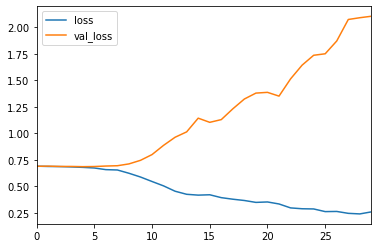

In [70]:
losses[['loss','val_loss']].plot()

In [71]:
print(model.metrics_names)
print(model.evaluate(X_test,y_test,verbose=0))

['loss', 'accuracy']
[2.1046411673227947, 0.5277778]


In [72]:
y_pred = model.predict_classes(X_test)

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.56      0.57       101
           1       0.46      0.48      0.47        79

    accuracy                           0.53       180
   macro avg       0.52      0.52      0.52       180
weighted avg       0.53      0.53      0.53       180



In [74]:
accuracy_score(y_test, y_pred)

0.5277777777777778

In [75]:
f1_score(y_test, y_pred)

0.4720496894409938

In [76]:
roc_auc_score(y_test, y_pred)

0.5226845469357062

In [96]:
model.save("models/specific_vect_nn.h5")

### Label attainable

In [77]:
attainable_features = smart_features.drop(columns=['label_specific', 'label_time_bound', 'label_unambiguity'])

In [78]:
X = attainable_features.drop('label_attainable', axis=1)
y = attainable_features['label_attainable']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [85]:
mms = MinMaxScaler()

In [86]:
X_train_scaled = mms.fit_transform(X_train)

In [87]:
X_test_scaled = mms.fit_transform(X_test)

In [88]:
att_xgb = XGBClassifier()

In [89]:
att_xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [90]:
y_pred = att_xgb.predict(X_test_scaled)

In [91]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.49      0.47        98
           1       0.58      0.55      0.57       127

    accuracy                           0.52       225
   macro avg       0.52      0.52      0.52       225
weighted avg       0.53      0.52      0.53       225



In [92]:
accuracy_score(y_test, y_pred)

0.5244444444444445

In [93]:
f1_score(y_test, y_pred)

0.5668016194331984

In [94]:
roc_auc_score(y_test, y_pred)

0.5204885103647758

In [118]:
with open('models/attainable_feat_xgb.pkl', 'wb') as f:
    pickle.dump(att_xgb, f)

#### Vectors approach

In [97]:
attainable_vectors = smart_text_vectors.drop(columns=['label_specific', 'label_time_bound'])

In [98]:
attainable_vectors.fillna('', inplace=True)

In [99]:
attainable_vectors.columns

Index(['goal_name_key_pos', 'label_attainable'], dtype='object')

In [100]:
text = attainable_vectors['goal_name_key_pos']
y = attainable_vectors['label_attainable']

In [101]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [103]:
att_v_xgb = XGBClassifier()

In [104]:
att_v_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [105]:
y_pred = att_v_xgb.predict(X_test)

In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.29      0.34        77
           1       0.56      0.69      0.62       103

    accuracy                           0.52       180
   macro avg       0.49      0.49      0.48       180
weighted avg       0.50      0.52      0.50       180



In [107]:
accuracy_score(y_test, y_pred)

0.5166666666666667

In [108]:
f1_score(y_test, y_pred)

0.6200873362445415

In [109]:
roc_auc_score(y_test, y_pred)

0.48751733703190014

In [130]:
with open('models/attainable_vect_xgb.pkl', 'wb') as f:
    pickle.dump(att_v_xgb, f)

#### Neural net (vectors)

In [110]:
text = attainable_vectors['goal_name_key_pos']
y = attainable_vectors['label_attainable']

In [111]:
token = Tokenizer()
token.fit_on_texts(text)

In [112]:
vocab_size = len(token.word_index) + 1
vocab_size

900

In [113]:
encoded_text = token.texts_to_sequences(text)

In [114]:
max_len = int()
for i in encoded_text:
    len_ = len(i)
    if len_ > max_len:
        max_len = len_
        
max_len

21

In [115]:
max_length = 21
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [117]:
vec_size = 142

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(64, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [118]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Wall time: 38.9 ms


In [119]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test= np.asarray(X_test)
y_test = np.asarray(y_test)

In [120]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [121]:
model.fit(X_train, y_train, epochs=600, validation_data=(X_test, y_test), callbacks=[early_stop])

Train on 719 samples, validate on 180 samples
Epoch 1/600
719/719 [==============================] - 2s 2ms/sample - loss: 0.6952 - accuracy: 0.5049 - val_loss: 0.6898 - val_accuracy: 0.5722
Epoch 2/600
719/719 [==============================] - 0s 347us/sample - loss: 0.6882 - accuracy: 0.5688 - val_loss: 0.6880 - val_accuracy: 0.5722
Epoch 3/600
719/719 [==============================] - 0s 348us/sample - loss: 0.6851 - accuracy: 0.5744 - val_loss: 0.6861 - val_accuracy: 0.5722
Epoch 4/600
719/719 [==============================] - 0s 357us/sample - loss: 0.6820 - accuracy: 0.5841 - val_loss: 0.6850 - val_accuracy: 0.5722
Epoch 5/600
719/719 [==============================] - 0s 347us/sample - loss: 0.6782 - accuracy: 0.5897 - val_loss: 0.6843 - val_accuracy: 0.5722
Epoch 6/600
719/719 [==============================] - 0s 336us/sample - loss: 0.6708 - accuracy: 0.6189 - val_loss: 0.6842 - val_accuracy: 0.5722
Epoch 7/600
719/719 [==============================] - 0s 329us/sample - l

In [122]:
losses = pd.DataFrame(model.history.history)

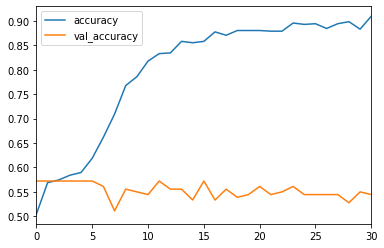

In [123]:
losses[['accuracy','val_accuracy']].plot()

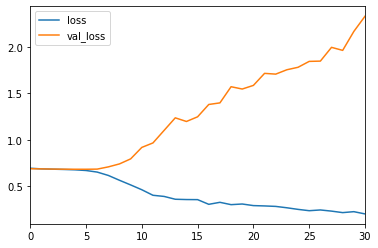

In [124]:
losses[['loss','val_loss']].plot()

In [125]:
print(model.metrics_names)
print(model.evaluate(X_test,y_test,verbose=0))

['loss', 'accuracy']
[2.3286325454711916, 0.54444444]


In [126]:
y_pred = model.predict_classes(X_test)

In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.32      0.38        77
           1       0.58      0.71      0.64       103

    accuracy                           0.54       180
   macro avg       0.52      0.52      0.51       180
weighted avg       0.53      0.54      0.53       180



In [128]:
accuracy_score(y_test, y_pred)

0.5444444444444444

In [129]:
f1_score(y_test, y_pred)

0.6403508771929824

In [130]:
roc_auc_score(y_test, y_pred)

0.5167065943764974

In [151]:
model.save("models/attainable_vect_nn.h5")

### Label time-bound

In [131]:
time_bound_features = smart_features.drop(columns=['label_specific', 'label_attainable', 'label_unambiguity'])

In [132]:
X = time_bound_features.drop('label_time_bound', axis=1)
y = time_bound_features['label_time_bound']

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
mms = MinMaxScaler()

In [135]:
X_train_scaled = mms.fit_transform(X_train)

In [136]:
X_test_scaled = mms.fit_transform(X_test)

In [137]:
tb_xgb = XGBClassifier()

In [138]:
tb_xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [139]:
y_pred = tb_xgb.predict(X_test_scaled)

In [140]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       145
           1       0.18      0.11      0.14        35

    accuracy                           0.73       180
   macro avg       0.49      0.50      0.49       180
weighted avg       0.68      0.73      0.70       180



In [141]:
accuracy_score(y_test, y_pred)

0.7277777777777777

In [142]:
f1_score(y_test, y_pred)

0.14035087719298245

In [143]:
roc_auc_score(y_test, y_pred)

0.49507389162561577

In [163]:
with open('models/time_bound_feat_xgb.pkl', 'wb') as f:
    pickle.dump(tb_xgb, f)

#### Vectors approach

In [144]:
time_bound_vectors = smart_text_vectors.drop(columns=['label_specific', 'label_attainable'])

In [145]:
time_bound_vectors.dropna(inplace=True)

In [146]:
text = time_bound_vectors['goal_name_key_pos']
y = time_bound_vectors['label_time_bound']

In [147]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [149]:
tb_v_xgb = XGBClassifier()

In [150]:
tb_v_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [151]:
y_pred = tb_v_xgb.predict(X_test)

In [152]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       149
           1       0.00      0.00      0.00        27

    accuracy                           0.84       176
   macro avg       0.42      0.49      0.46       176
weighted avg       0.72      0.84      0.77       176



In [153]:
accuracy_score(y_test, y_pred)

0.8352272727272727

In [154]:
f1_score(y_test, y_pred)

0.0

In [155]:
roc_auc_score(y_test, y_pred)

0.49328859060402686

In [174]:
with open('models/time_bound_vect_xgb.pkl', 'wb') as f:
    pickle.dump(tb_v_xgb, f)

#### Neural net approach

In [156]:
text = time_bound_vectors['goal_name_key_pos']
y = time_bound_vectors['label_time_bound']

In [157]:
token = Tokenizer()
token.fit_on_texts(text)

In [158]:
vocab_size = len(token.word_index) + 1
vocab_size

900

In [159]:
encoded_text = token.texts_to_sequences(text)

In [160]:
max_len = int()
for i in encoded_text:
    len_ = len(i)
    if len_ > max_len:
        max_len = len_
        
max_len

21

In [161]:
max_length = 21
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [164]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(64, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [165]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Wall time: 32.5 ms


In [166]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test= np.asarray(X_test)
y_test = np.asarray(y_test)

In [167]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [168]:
model.fit(X_train, y_train, epochs=600, validation_data=(X_test, y_test), callbacks=[early_stop])

Train on 700 samples, validate on 176 samples
Epoch 1/600
700/700 [==============================] - 1s 2ms/sample - loss: 0.6669 - accuracy: 0.7100 - val_loss: 0.6504 - val_accuracy: 0.8466
Epoch 2/600
700/700 [==============================] - 0s 307us/sample - loss: 0.5297 - accuracy: 0.8486 - val_loss: 0.5250 - val_accuracy: 0.8466
Epoch 3/600
700/700 [==============================] - 0s 313us/sample - loss: 0.4347 - accuracy: 0.8486 - val_loss: 0.5008 - val_accuracy: 0.8466
Epoch 4/600
700/700 [==============================] - 0s 315us/sample - loss: 0.4328 - accuracy: 0.8486 - val_loss: 0.5177 - val_accuracy: 0.8466
Epoch 5/600
700/700 [==============================] - 0s 311us/sample - loss: 0.4319 - accuracy: 0.8486 - val_loss: 0.5170 - val_accuracy: 0.8466
Epoch 6/600
700/700 [==============================] - 0s 309us/sample - loss: 0.4362 - accuracy: 0.8486 - val_loss: 0.5153 - val_accuracy: 0.8466
Epoch 7/600
700/700 [==============================] - 0s 313us/sample - l

In [169]:
losses = pd.DataFrame(model.history.history)

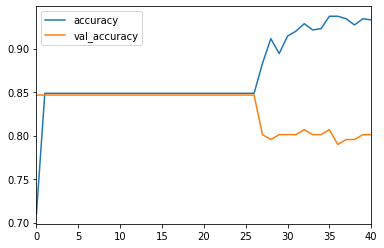

In [170]:
losses[['accuracy','val_accuracy']].plot()

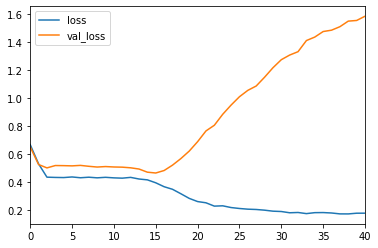

In [171]:
losses[['loss','val_loss']].plot()

In [172]:
print(model.metrics_names)
print(model.evaluate(X_test,y_test,verbose=0))

['loss', 'accuracy']
[1.583661599592729, 0.8011364]


In [173]:
y_pred = model.predict_classes(X_test)

In [174]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       149
           1       0.28      0.19      0.22        27

    accuracy                           0.80       176
   macro avg       0.57      0.55      0.55       176
weighted avg       0.77      0.80      0.78       176



In [175]:
accuracy_score(y_test, y_pred)

0.8011363636363636

In [176]:
f1_score(y_test, y_pred)

0.22222222222222224

In [177]:
roc_auc_score(y_test, y_pred)

0.5489684315187671

In [195]:
model.save("models/time_bound_vect_nn.h5")